In [8]:
%run Imports.ipynb

In [9]:
import warnings
warnings.simplefilter('ignore')

In [10]:
conf = pyspark.SparkConf()
spark = SparkSession.builder.appName("Rank").getOrCreate()

In [11]:
#df1=spark.read.parquet("output_2202508.parquet")

In [12]:
df1=spark.read.parquet("/Users/rose/Documents/CleanDuneData/*")

In [13]:
#path = "C:/Users/MAITRI/OneDrive/Documents/load_m/*"
#path = "C:/path/to/parquet/files"

# Use spark.read.parquet() to read all the Parquet files in the folder
#df = spark.read.parquet(path)


In [14]:
df1.count()

3898970

In [15]:
df1.createOrReplaceTempView("Load")

Main Query

In [16]:
df_all = spark.sql("SELECT * FROM ( SELECT n1.buyer, n1.original_currency, n1.nft_token_id, n1.nft_contract_address, n1.original_amount as Bought, n2.original_amount as Sold, n1.block_time as Bought_Timestamp, n2.block_time as Sold_Timestamp,n1.usd_amount as Bought_amount, n2.usd_amount as Sold_amount, (n2.usd_amount - n1.usd_amount) as net, n1.platform as n1platform, n2.platform as n2platform FROM Load n1, Load n2 where n1.buyer = n2.seller AND  n2.block_time > n1.block_time AND  n1.nft_token_id is not null AND n1.nft_token_id = n2.nft_token_id AND n1.nft_contract_address = n2.nft_contract_address) holdings")

In [17]:
df_all.columns

['buyer',
 'original_currency',
 'nft_token_id',
 'nft_contract_address',
 'Bought',
 'Sold',
 'Bought_Timestamp',
 'Sold_Timestamp',
 'Bought_amount',
 'Sold_amount',
 'net',
 'n1platform',
 'n2platform']

In [18]:
df_all.schema

StructType([StructField('buyer', StringType(), True), StructField('original_currency', StringType(), True), StructField('nft_token_id', StringType(), True), StructField('nft_contract_address', StringType(), True), StructField('Bought', DoubleType(), True), StructField('Sold', DoubleType(), True), StructField('Bought_Timestamp', TimestampType(), True), StructField('Sold_Timestamp', TimestampType(), True), StructField('Bought_amount', DoubleType(), True), StructField('Sold_amount', DoubleType(), True), StructField('net', DoubleType(), True), StructField('n1platform', StringType(), True), StructField('n2platform', StringType(), True)])

In [19]:
type(df_all)

pyspark.sql.dataframe.DataFrame

In [20]:
df_all.select('buyer','Bought_amount','Sold_amount','net').show(20)

+--------------------+-------------+------------+-------------------+
|               buyer|Bought_amount| Sold_amount|                net|
+--------------------+-------------+------------+-------------------+
|\x0000005c7dc69d4...|    837.48308|    1078.273| 240.78991999999994|
|\x00003e81818a2f1...|   125.698549|  173.522188|          47.823639|
|\x0005bb8bdcbbf4a...|     775.9004|   1133.2491|           357.3487|
|\x00079e801ad1382...|    178.37568|   1289.0346| 1110.6589199999999|
|\x000cd27f10dffac...|     1405.935|   55277.167|          53871.232|
|\x000cef8f0ab0a2f...|    694.86968|1094.2062762| 399.33659620000003|
|\x000e0ed8a7307e1...|      905.931|   519.35032|-386.58068000000003|
|\x00110e09134aec0...|   200.720832|   188.68224|-12.038591999999994|
|\x00110e09134aec0...|   200.720832|  250.395432|            49.6746|
|\x00110e09134aec0...|   200.720832|   278.09376|  77.37292799999997|
|\x00110e09134aec0...|   200.720832|  248.424224|  47.70339200000001|
|\x00110e09134aec0..

# Ranking 1 - average amount spent (here profit , loss automatically done)

In [21]:
df_avg = df_all.groupBy("buyer").agg(avg("net").alias("avg_spent"))
# score1 based on avg_spent
df_rule_avg_spent_pd=df_avg.toPandas()

# Calculate percentiles for customers with avg_spent > 0
df_positive = df_rule_avg_spent_pd[df_rule_avg_spent_pd['avg_spent'] > 0]
percentiles = df_positive['avg_spent'].rank(pct=True)
df_positive['Score1'] = percentiles * 100

# Set score to 0 for customers with avg_spent < 0
df_negative = df_rule_avg_spent_pd[df_rule_avg_spent_pd['avg_spent'] <= 0]
df_negative['Score1'] = 0

# Combine positive and negative dataframes
df_combined = pd.concat([df_positive, df_negative], axis=0)

# Print result
print(df_combined)
print(df_combined['Score1'].unique())
df_rule_avg_spent=spark.createDataFrame(df_combined)

23/04/19 11:47:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:15 WARN RowBasedKeyValueBatch: Calling spill() on

                                             buyer    avg_spent     Score1
1       \x014fd068938fa1965be36a9244ddf6d37f6b88cb    89.940925  29.780646
3       \x0312b9e6627d9a49cf07a3b5af1f18ad8d8e39db  1866.865157  87.709605
6       \x06085d8c8d119a8a922c49610efb493f6f910772    41.081660  18.506226
7       \x0979ce762b7433fdce2a54cfef107d5295b81c4a   135.453858  37.572691
8       \x0a52279e62a5b7a9c1f3d4afa439e4fb9ec07edc    42.250928  18.829403
...                                            ...          ...        ...
186022  \xc0c8146b7ba7be02b8bbb2c858f0633f223637d7  -318.002800   0.000000
186027  \xcfadfb9eebbaf3b5e85a256f260c195826bb5352  -488.890500   0.000000
186029  \xe0d3851eb01cde810436a054f4211e31a2fe0a82  -809.368120   0.000000
186031  \xe282780e50937a2490831e4539bbb5f3f564e004  -588.149493   0.000000
186033  \xed1efb8184a6d9498e98695087da3903376b925a -3484.871500   0.000000

[186035 rows x 3 columns]
[29.78064616 87.70960532 18.50622648 ... 37.86974233 31.29009473
  0.    

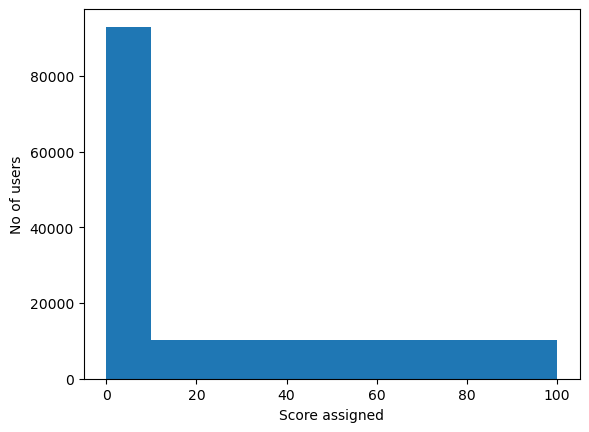

In [22]:
plt.hist(df_combined["Score1"])
plt.xlabel("Score assigned")
plt.ylabel("No of users")
plt.title("")
plt.show()

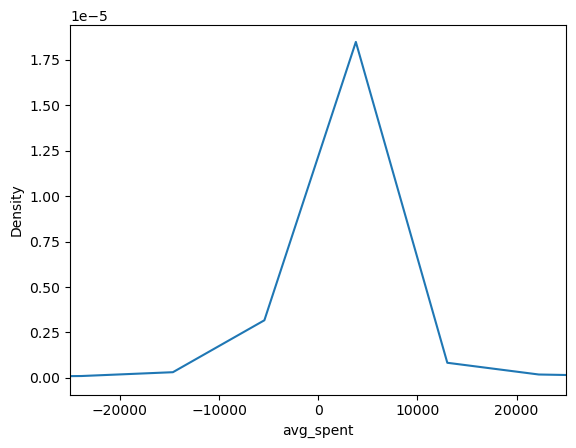

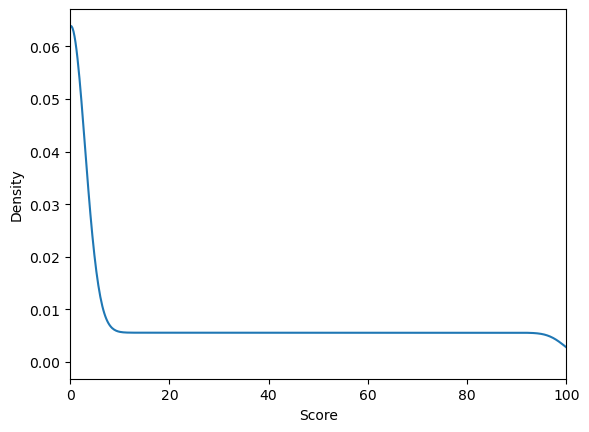

In [23]:
# import seaborn as sns
df_combined['avg_spent'].plot.kde()
plt.xlabel('avg_spent')
plt.ylabel('Density')
plt.title("")
plt.xlim(-25000,25000)
plt.show()
df_combined['Score1'].plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(0,100)
plt.show()

# sns.kdeplot(data=df_rule_avg_spent_pd, x='avg_spent')
# sns.set_xlim(0,2)
# plt.show()

In [24]:
df_avg = df_all.groupBy("buyer").agg(avg("net").alias("avg_spent"))
# score1 based on avg_spent
df_rule_avg_spent_pd=df_avg.toPandas()

df_rule_avg_spent_pd.loc[df_rule_avg_spent_pd['avg_spent'] <= 0, 'Score1'] = 0


hist, bins = pd.cut(df_rule_avg_spent_pd['avg_spent'], bins=100, labels=False, retbins=True, right=False)
df_rule_avg_spent_pd['Score1'] = hist + 1

print(df_rule_avg_spent_pd)

23/04/19 11:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:47:52 WARN RowBasedKeyValueBatch: Calling spill() on

                                             buyer    avg_spent  Score1
0       \x006b82530c7985fd0084382e866db39a6c5c0578  -252.267914      27
1       \x014fd068938fa1965be36a9244ddf6d37f6b88cb    89.940925      27
2       \x01981e7284ade335883f75927fae1b70fac44d71  -128.700244      27
3       \x0312b9e6627d9a49cf07a3b5af1f18ad8d8e39db  1866.865157      27
4       \x05379b307e6ae02e522fb134fad1254a4e7fbac1   -80.200510      27
...                                            ...          ...     ...
186030  \xe25cf7322526cfef5ca841deb14323f9ada1234a  1839.846200      27
186031  \xe282780e50937a2490831e4539bbb5f3f564e004  -588.149493      27
186032  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d   137.396000      27
186033  \xed1efb8184a6d9498e98695087da3903376b925a -3484.871500      27
186034  \xf49b67a2b2fc0904cb12a2c41c7d2007841c04a0    97.844091      27

[186035 rows x 3 columns]


# Ranking 2 - number of transactions

In [25]:
df_count = df_all.groupBy("buyer").agg(count("*").alias("number_txns"))

# score2 based on number_txns
df_rule_number_txns_pd=df_count.toPandas()

df_negative = df_rule_number_txns_pd[df_rule_number_txns_pd['number_txns'] <= 1]
df_negative['Score'] = 0

percentiles = df_rule_number_txns_pd['number_txns'].rank(pct=True)
df_rule_number_txns_pd['Score2'] = percentiles * 100

# Print result
print(df_rule_number_txns_pd)
print(df_rule_number_txns_pd['Score2'].unique())
df_rule_number_txns=spark.createDataFrame(df_rule_number_txns_pd)

23/04/19 11:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:48:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:11 WARN RowBasedKeyValueBatch: Calling spill() on

23/04/19 11:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


                                             buyer  number_txns     Score2
0       \x006b82530c7985fd0084382e866db39a6c5c0578           12  96.970194
1       \x014fd068938fa1965be36a9244ddf6d37f6b88cb           19  98.658586
2       \x01981e7284ade335883f75927fae1b70fac44d71           18  98.525009
3       \x0312b9e6627d9a49cf07a3b5af1f18ad8d8e39db            6  90.421964
4       \x03a3da04bd4a888ed473a9c6bd90a13165f78e72            1  26.398527
...                                            ...          ...        ...
186030  \xe0d3851eb01cde810436a054f4211e31a2fe0a82            1  26.398527
186031  \xe25cf7322526cfef5ca841deb14323f9ada1234a            1  26.398527
186032  \xe282780e50937a2490831e4539bbb5f3f564e004            2  61.975166
186033  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d            1  26.398527
186034  \xf49b67a2b2fc0904cb12a2c41c7d2007841c04a0            1  26.398527

[186035 rows x 3 columns]
[ 96.97019378  98.65858575  98.52500873  90.42196361  26.39852716
  75.70

In [26]:
import pandas as pd
import numpy as np

df_count = df_all.groupBy("buyer").agg(count("*").alias("number_txns"))

# score2 based on number_txns
df_rule_number_txns_pd=df_count.toPandas()

# winsorize the transaction counts
p1, p99 = np.percentile(df_rule_number_txns_pd['number_txns'], [1, 99])
df_rule_number_txns_pd['winsorized_transactions'] = np.clip(df_rule_number_txns_pd['number_txns'], p1, p99)

# calculate the winsorized z-score of each transaction count
mean = df_rule_number_txns_pd['winsorized_transactions'].mean()
std = df_rule_number_txns_pd['winsorized_transactions'].std()
df_rule_number_txns_pd['z_value'] = (df_rule_number_txns_pd['winsorized_transactions'] - mean) / std

# assign scores based on the z-score
df_rule_number_txns_pd['zscore'] = pd.cut(df_rule_number_txns_pd['z_value'],bins=10, labels=[10, 20, 30, 40, 50, 60, 70, 80, 90,100])

print(df_rule_number_txns_pd)


23/04/19 11:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:48:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:48:37 WARN RowBasedKeyValueBatch: Calling spill() on

                                             buyer  number_txns  \
0       \x006b82530c7985fd0084382e866db39a6c5c0578           12   
1       \x014fd068938fa1965be36a9244ddf6d37f6b88cb           19   
2       \x01981e7284ade335883f75927fae1b70fac44d71           18   
3       \x0312b9e6627d9a49cf07a3b5af1f18ad8d8e39db            6   
4       \x03a3da04bd4a888ed473a9c6bd90a13165f78e72            1   
...                                            ...          ...   
186030  \xe0d3851eb01cde810436a054f4211e31a2fe0a82            1   
186031  \xe25cf7322526cfef5ca841deb14323f9ada1234a            1   
186032  \xe282780e50937a2490831e4539bbb5f3f564e004            2   
186033  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d            1   
186034  \xf49b67a2b2fc0904cb12a2c41c7d2007841c04a0            1   

        winsorized_transactions   z_value zscore  
0                          12.0  2.696353     50  
1                          19.0  4.728664     90  
2                          18.0  4.438333 

In [27]:
df_rule_number_txns_pd['zscore'].value_counts()

10     149291
20      16586
30       7742
40       4085
50       3149
100      2196
60       1155
70        837
80        589
90        405
Name: zscore, dtype: int64

In [28]:
# df_rule_number_txns_pd['Score3t'] = pd.qcut(df_rule_number_txns_pd['number_txns'], q=100, labels=False, duplicates='drop')

# # normalize the scores to a scale of 1 to 100
# max_score = df_rule_number_txns_pd['Score3t'].max()
# df_rule_number_txns_pd['Score3t'] = (df_rule_number_txns_pd['Score3t'] / max_score) * 100

# # set the score of the top 1% customers to 100
# top_1_percent = int(len(df_rule_number_txns_pd) * 0.01)
# top_1_percent_customers = df_rule_number_txns_pd.nlargest(top_1_percent, 'number_txns')
# df_rule_number_txns_pd.loc[top_1_percent_customers.index, 'Score3t'] = 100

# # print the dataframe with scores
# print(df_rule_number_txns_pd)

In [29]:
df_rule_number_txns_pd['number_txns'].describe()

count    186035.000000
mean          2.969624
std           7.031336
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         605.000000
Name: number_txns, dtype: float64

In [30]:
df_rule_number_txns_pd.sort_values(by = 'number_txns', ascending = False)

,buyer,number_txns,winsorized_transactions,z_value,zscore
145824,\xa43958e85e4a64977a9d3d2c6a053808aa5a9ed6,605,23.0,5.889984,100
48009,\x6599ec8d67f5258409cd0b01d320abc08b74ddb6,588,23.0,5.889984,100
20004,\x2727d7080c10b6cb66f176e6a897dd82eaf7e2b8,485,23.0,5.889984,100
44544,\x0b3e6c6b9ce74f891dda7dab07d21149ab0ec09c,339,23.0,5.889984,100
184539,\xc154b8b310461716d50b18980a84444c1c780ba4,332,23.0,5.889984,100
...,...,...,...,...,...
102285,\xf47f2edaa3b1308e53a093797ebf42e1bbd72d63,1,1.0,-0.497278,10
102283,\xf3442dd014446b60d19cdcce0313160c3e515d41,1,1.0,-0.497278,10
29407,\x0f7de8cd5e0fd700af34c5d5ff214b0aca5c49d7,1,1.0,-0.497278,10
29409,\x109a63fd467c7dc684583db607f8a19bb11749d8,1,1.0,-0.497278,10


In [31]:
# df_count = df_all.groupBy("buyer").agg(count("*").alias("number_txns"))
# # score2 based on number_txns
# df_rule_number_txns_pd=df_count.toPandas()
# hist, bins=pd.cut(df_rule_number_txns_pd['number_txns'],bins=100,labels=False,retbins=True,right=False)
# df_rule_number_txns_pd['Score2']=hist
# df_rule_number_txns_pd['Score2']+=1
# print(df_rule_number_txns_pd)
# #print unique score2 values assigned
# print(df_rule_number_txns_pd['Score2'].unique())
# #converting to sparkdf
# df_rule_number_txns=spark.createDataFrame(df_rule_number_txns_pd)

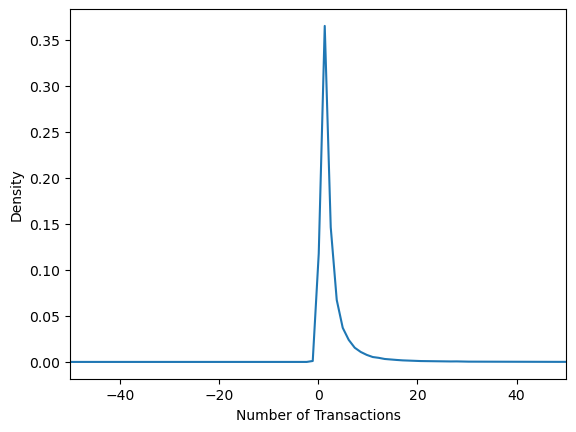

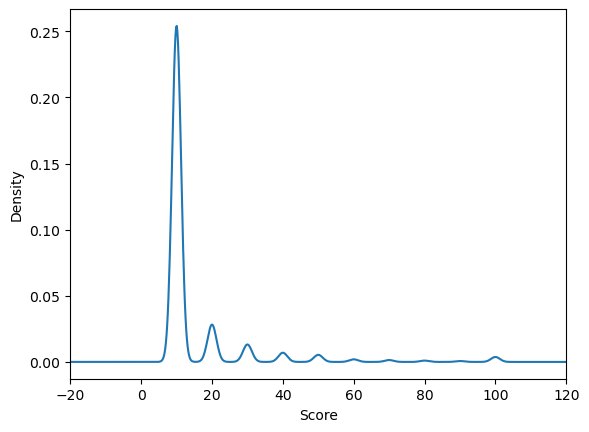

In [32]:
df_rule_number_txns_pd['number_txns'].plot.kde()
plt.xlabel('Number of Transactions')
plt.ylabel('Density')
plt.title("")
plt.xlim(-50,50)
plt.show()

df_rule_number_txns_pd['zscore'].astype(int).plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(-20,120)
plt.show()

# Diversity Ranking 3 - Number of Nft contract address held

In [33]:
df_num_nftcontract = df_all.groupBy("buyer").agg(countDistinct("nft_contract_address").alias("num_nftcontract"))
# score3 based on num_nftcontract
df_rule_num_nftcontract_pd=df_num_nftcontract.toPandas()

percentiles = df_rule_num_nftcontract_pd['num_nftcontract'].rank(pct=True)
df_rule_num_nftcontract_pd['Score3'] = percentiles * 100

print(df_rule_num_nftcontract_pd)
#print unique score3 values assigned
print(df_rule_num_nftcontract_pd['Score3'].unique())
#converting to sparkdf
df_rule_num_nftcontract=spark.createDataFrame(df_rule_num_nftcontract_pd)

                                             buyer  num_nftcontract     Score3
0       \x431e83d651c30ef4f9c950a7e82fbf9c58ce5efa                1  33.447738
1       \x70299f32683e4dee59f96e37c95bbff2f39cfbf2                2  75.545731
2       \xde827780ddc18752064e9d8d31ec9cd7f5f5bb7f                2  75.545731
3       \x32488429c7693cde04605ec65fa56207c8f290b2                2  75.545731
4       \x9035b2dec8bac0bcc6fd34e8299c32db698b67db                1  33.447738
...                                            ...              ...        ...
186030  \x7a44d5004b9498534c44c5fe21620e183f13546d                1  33.447738
186031  \x0430bac0344e152ade170ffa4c0e3140dc7def41                1  33.447738
186032  \x3f1da7d513d359a4aa4fced8ab1bb92501fb5dff                1  33.447738
186033  \xf49b67a2b2fc0904cb12a2c41c7d2007841c04a0                1  33.447738
186034  \x92218940e9ae133cf887632db0ad07c57048fd8d                1  33.447738

[186035 rows x 3 columns]
[ 33.44773833  75.5457306

In [65]:
# min_score = 10
# max_score = 100


# df_rule_num_nftcontract_pd['Score3'] = min_score + (df['value'] - df['value'].min()) * (max_score - min_score) / (df['value'].max() - df['value'].min())

# print(df)


In [35]:
df_rule_num_nftcontract_pd['num_nftcontract'].value_counts()

1     124448
2      32186
3      13623
4       6750
5       3653
6       2124
7       1212
8        807
9        458
10       253
11       183
12       117
13        86
14        49
15        25
16        22
17         9
20         8
18         8
19         5
21         4
23         1
26         1
28         1
24         1
27         1
Name: num_nftcontract, dtype: int64

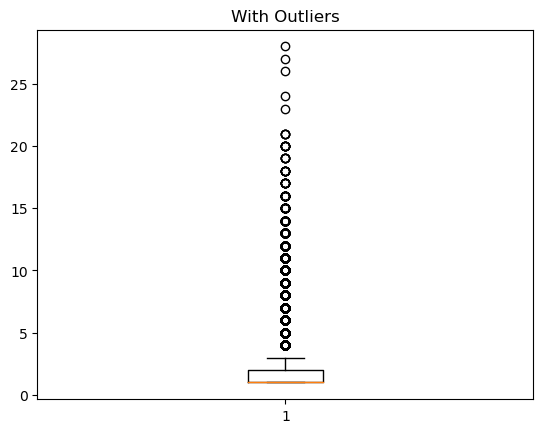

1    124448
2     32186
3     13623
Name: num_nftcontract, dtype: int64


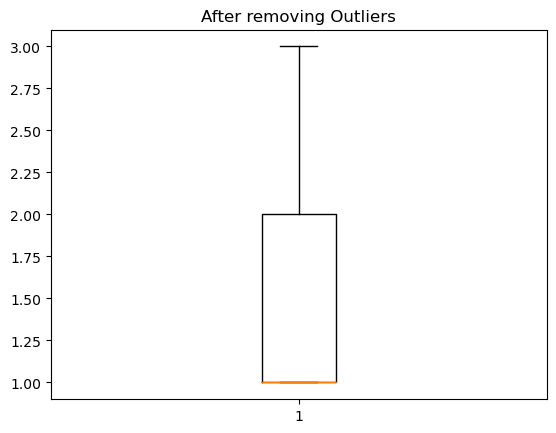

In [95]:
plt.boxplot(df_rule_num_nftcontract_pd['num_nftcontract'])
plt.title('With Outliers')
plt.show()
Q1 = df_rule_num_nftcontract_pd['num_nftcontract'].quantile(0.25)
Q3 = df_rule_num_nftcontract_pd['num_nftcontract'].quantile(0.75)
IQR = Q3 - Q1

# Identify any values that fall outside of 1.5 times the IQR
#outliers = df_rule_num_nftcontract_pd[(df_rule_num_nftcontract_pd['num_nftcontract'] < Q1 - 1.5*IQR) | (df_rule_num_nftcontract_pd['num_nftcontract'] > Q3 + 1.5*IQR)]
outliers_df_rule_num_nftcontract_pd = df_rule_num_nftcontract_pd[(df_rule_num_nftcontract_pd['num_nftcontract'] >= Q1 - 1.5*IQR) & (df_rule_num_nftcontract_pd['num_nftcontract'] <= Q3 + 1.5*IQR)]
print(outliers_df_rule_num_nftcontract_pd['num_nftcontract'].value_counts())
plt.boxplot(outliers_df_rule_num_nftcontract_pd['num_nftcontract'])
plt.title('After removing Outliers')
plt.show()

In [36]:
df_rule_num_nftcontract_pd.sort_values(by = 'num_nftcontract', ascending = True)

,buyer,num_nftcontract,Score3
0,\x431e83d651c30ef4f9c950a7e82fbf9c58ce5efa,1,33.447738
111851,\x2b0ec94e217d27b4b9a4b9cdcefb682309cd2331,1,33.447738
111853,\xe0428643becaddc2f6b110446f75a712200c1a97,1,33.447738
111854,\x176bc0375ab4980b4f999db8215f1998434842fa,1,33.447738
111855,\xcc33e540c7efc17c05b7d98347b540cf15fcd1a3,1,33.447738
...,...,...,...
45101,\xb1468e7020a5b309f9d4e2a5c857ecac96de5f64,23,99.997850
160341,\xbc4cd003b24d0d46ad229bc707b77fae8446d6af,24,99.998387
45314,\x365c211f49ee7f3667456abb3a130c738884099d,26,99.998925
164203,\x78f0803235057a902373e915c0c833c4aa154e13,27,99.999462


In [37]:
#df_rule_num_nftcontract_pd.sort_values(by = "num_nftcontract", ascending = False)

In [38]:
# df_num_nftcontract = df_all.groupBy("buyer").agg(countDistinct("nft_contract_address").alias("num_nftcontract"))
# # score3 based on num_nftcontract
# df_rule_num_nftcontract_pd=df_num_nftcontract.toPandas()
# hist, bins=pd.cut(df_rule_num_nftcontract_pd['num_nftcontract'],bins=100,labels=False,retbins=True,right=False)
# df_rule_num_nftcontract_pd['Score3']=hist
# df_rule_num_nftcontract_pd['Score3']+=1
# print(df_rule_num_nftcontract_pd)
# #print unique score3 values assigned
# print(df_rule_num_nftcontract_pd['Score3'].unique())
# #converting to sparkdf
# df_rule_num_nftcontract=spark.createDataFrame(df_rule_num_nftcontract_pd)

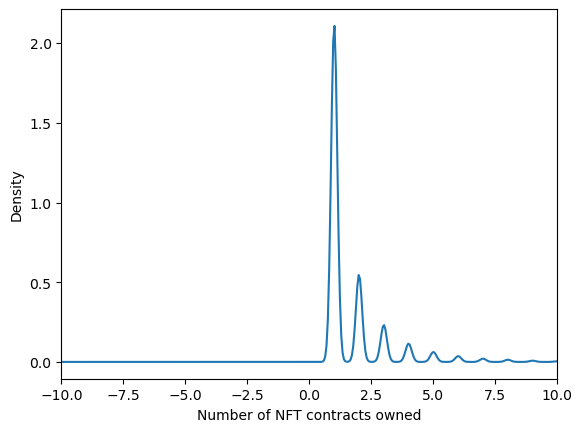

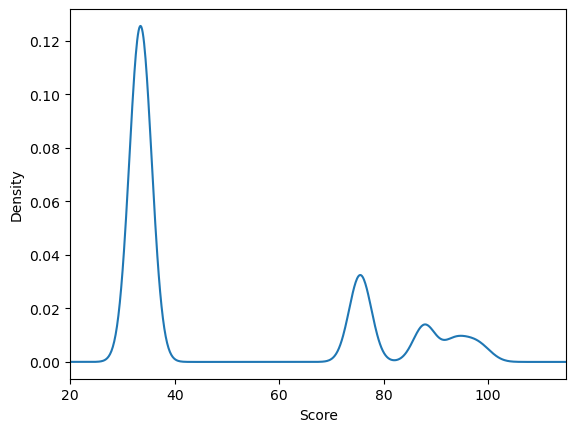

In [39]:
df_rule_num_nftcontract_pd['num_nftcontract'].plot.kde()
plt.xlabel('Number of NFT contracts owned')
plt.ylabel('Density')
plt.title("")
plt.xlim(-10,10)
plt.show()

df_rule_num_nftcontract_pd['Score3'].plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(20,115)
plt.show()

# Diversity Ranking 4 - Number of unique currencies transaction done in

In [40]:
unique_names = df_all.select(col("original_currency")).distinct().rdd.flatMap(lambda x: x).collect()

In [42]:
df_currency = df_all.groupBy("buyer").agg(countDistinct("original_currency").alias("num_currency"))
# score4 based on num_currency
df_rule_num_currency_pd=df_currency.toPandas()

percentiles = df_rule_num_currency_pd['num_currency'].rank(pct=True)
df_rule_num_currency_pd['Score4'] = percentiles * 100

print(df_rule_num_currency_pd)
#print unique score4 values assigned
print(df_rule_num_currency_pd['Score4'].unique())
#converting back to spark df
df_rule_num_currency=spark.createDataFrame(df_rule_num_currency_pd)

                                             buyer  num_currency     Score4
0       \x375751f0159c9bb29ec2945a5767bb9d3874712f             1  48.130728
1       \x3bd12ee645be8734170c4e7a86448a410903eaed             1  48.130728
2       \xf9e5db0610350385f83e6290e040fe99365548da             1  48.130728
3       \x1773fb4569491ccd6da5f4eed8359bf61f9bf095             1  48.130728
4       \x890652186e45f7be558eadfdde949307249a47f0             1  48.130728
...                                            ...           ...        ...
186030  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d             1  48.130728
186031  \xb40cab161bf5f5f0669ce661c7d9d6e269461d9a             1  48.130728
186032  \x69942f8e403b9d505e2da8a7a2056d9638805dcd             1  48.130728
186033  \x7a44d5004b9498534c44c5fe21620e183f13546d             1  48.130728
186034  \xc5bd99f6fd29d26beba91a171d519107c6d60201             1  48.130728

[186035 rows x 3 columns]
[48.13072809 98.11970866 99.9887118  99.99973123]


In [43]:
df_rule_num_currency_pd['num_currency'].value_counts()

1    179079
2      6915
3        39
4         2
Name: num_currency, dtype: int64

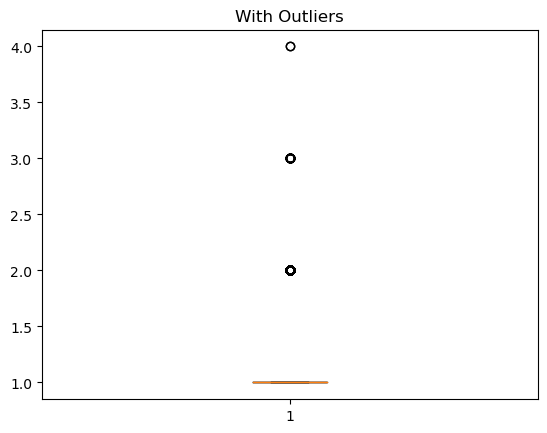

1    179079
Name: num_currency, dtype: int64


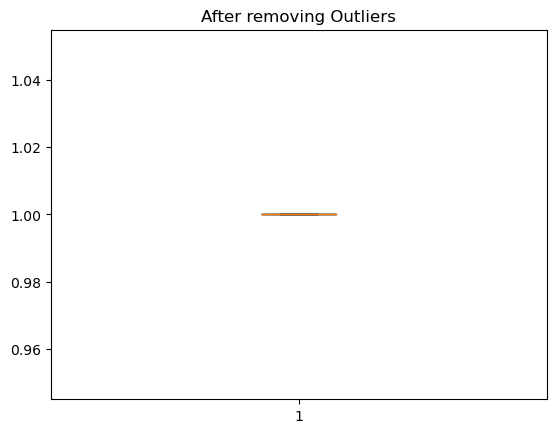

In [96]:
plt.boxplot(df_rule_num_currency_pd['num_currency'])
plt.title('With Outliers')
plt.show()
Q1 = df_rule_num_currency_pd['num_currency'].quantile(0.25)
Q3 = df_rule_num_currency_pd['num_currency'].quantile(0.75)
IQR = Q3 - Q1

# Identify any values that fall outside of 1.5 times the IQR
outliers_df_rule_num_currency_pd = df_rule_num_currency_pd[(df_rule_num_currency_pd['num_currency'] >= Q1 - 1.5*IQR) & (df_rule_num_currency_pd['num_currency'] <= Q3 + 1.5*IQR)]
print(outliers_df_rule_num_currency_pd['num_currency'].value_counts())
plt.boxplot(outliers_df_rule_num_currency_pd['num_currency'])
plt.title('After removing Outliers')
plt.show()

In [44]:
# # df_currency = df_all.groupBy("buyer").agg(countDistinct("original_currency").alias("num_currency")).orderBy(desc("num_currency"))
# df_currency = df_all.groupBy("buyer").agg(countDistinct("original_currency").alias("num_currency"))
# # score4 based on num_currency
# df_rule_num_currency_pd=df_currency.toPandas()
# hist, bins=pd.cut(df_rule_num_currency_pd['num_currency'],bins=100,labels=False,retbins=True,right=False)
# df_rule_num_currency_pd['Score4']=hist
# df_rule_num_currency_pd['Score4']+=1
# print(df_rule_num_currency_pd)
# #print unique score4 values assigned
# print(df_rule_num_currency_pd['Score4'].unique())
# #converting back to spark df
# df_rule_num_currency=spark.createDataFrame(df_rule_num_currency_pd)

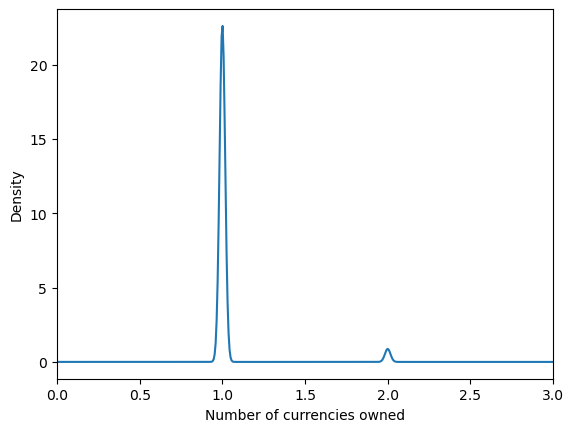

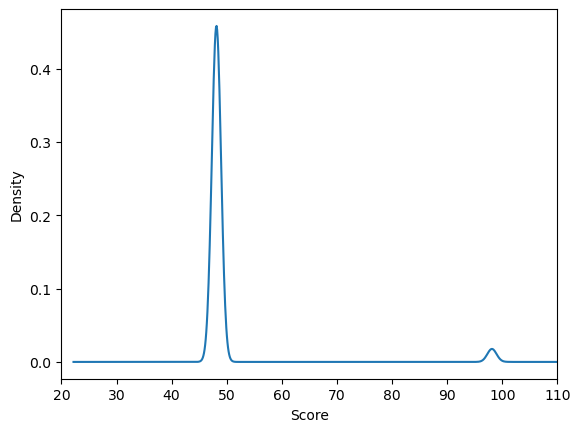

In [45]:
df_rule_num_currency_pd['num_currency'].plot.kde()
plt.xlabel('Number of currencies owned')
plt.ylabel('Density')
plt.title("")
plt.xlim(0,3)
plt.show()

df_rule_num_currency_pd['Score4'].plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(20,110)
plt.show()

In [46]:
# data_collect = df_all.collect()

# Diversity Ranking 5 - Average Duration (in seconds)

In [47]:
# df_all = df_all.withColumn("duration", (col("Sold_Timestamp") - col("Bought_Timestamp")))
df_all = df_all.withColumn("duration", (unix_timestamp(col("Sold_Timestamp")) - unix_timestamp(col("Bought_Timestamp"))))

In [48]:
df_all.select('duration').show(5)

+--------+
|duration|
+--------+
|  298840|
|   37944|
|   91081|
| 4252760|
| 6705652|
+--------+
only showing top 5 rows



In [49]:
df_avg_duration = df_all.groupBy("buyer").agg(avg("duration").alias("avg_duration"))
# score4 based on num_currency
df_rule_avg_duration_pd=df_avg_duration.toPandas()

percentiles = df_rule_avg_duration_pd['avg_duration'].rank(pct=True)
df_rule_avg_duration_pd['Score5'] = percentiles * 100

print(df_rule_avg_duration_pd)
#print unique score5 values assigned
print(df_rule_avg_duration_pd['Score5'].unique())
#converting to sparkdf
df_rule_avg_duration=spark.createDataFrame(df_rule_avg_duration_pd)

23/04/19 11:56:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:56:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:56:50 WARN RowBasedKeyValueBatch: Calling spill() on

                                             buyer  avg_duration     Score5
0       \x006b82530c7985fd0084382e866db39a6c5c0578  3.849958e+06  83.455264
1       \x014fd068938fa1965be36a9244ddf6d37f6b88cb  1.528443e+06  64.541619
2       \x01981e7284ade335883f75927fae1b70fac44d71  8.420664e+05  51.706937
3       \x0312b9e6627d9a49cf07a3b5af1f18ad8d8e39db  2.391315e+06  74.150026
4       \x03a3da04bd4a888ed473a9c6bd90a13165f78e72  8.280000e+02   1.190636
...                                            ...           ...        ...
186030  \xe0d3851eb01cde810436a054f4211e31a2fe0a82  1.754641e+06  67.550730
186031  \xe25cf7322526cfef5ca841deb14323f9ada1234a  5.060740e+05  41.046040
186032  \xe282780e50937a2490831e4539bbb5f3f564e004  6.212410e+05  45.393071
186033  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d  9.421300e+04  17.636466
186034  \xf49b67a2b2fc0904cb12a2c41c7d2007841c04a0  1.046440e+07  95.764238

[186035 rows x 3 columns]
[83.45526379 64.54161851 51.70693687 ... 45.3930712  17.63646

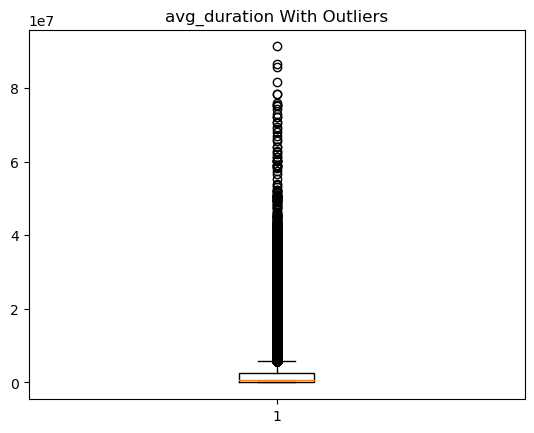

312.0        31
228.0        29
384.0        28
300.0        27
252.0        27
             ..
2393177.0     1
1563804.0     1
45235.0       1
168366.0      1
94213.0       1
Name: avg_duration, Length: 138817, dtype: int64


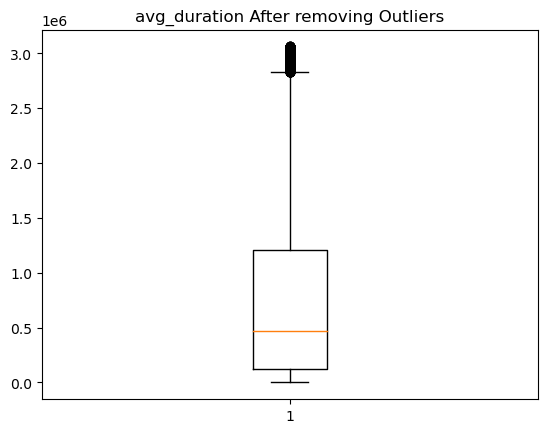

In [104]:
plt.boxplot(df_rule_avg_duration_pd['avg_duration'])
plt.title('avg_duration With Outliers')
plt.show()
Q1 = df_rule_avg_duration_pd['avg_duration'].quantile(0.25)
Q3 = df_rule_avg_duration_pd['avg_duration'].quantile(0.75)
IQR = Q3 - Q1

# Identify any values that fall outside of 1.5 times the IQR
outliers_df_rule_avg_duration_pd = df_rule_avg_duration_pd[(df_rule_avg_duration_pd['avg_duration'] >= Q1 - 0.25*IQR) & (df_rule_avg_duration_pd['avg_duration'] <= Q3 + 0.25*IQR)]
print(outliers_df_rule_avg_duration_pd['avg_duration'].value_counts())
plt.boxplot(outliers_df_rule_avg_duration_pd['avg_duration'])
plt.title('avg_duration After removing Outliers')
plt.show()

In [50]:
df_rule_avg_duration_pd.sort_values(by = "avg_duration", ascending = False)

,buyer,avg_duration,Score5
59922,\x9efea04be978275426e5e6c7ecd10206d47cfa0d,91290008.0,100.000000
7763,\x3311d07b4cb4450778fa036aaf1b1ceed4b39b4f,86507489.0,99.999462
177845,\xbaba92b7822a56c05554ab5d1bc1d0b7e212499d,85695646.0,99.998925
113481,\xc553ab5a21735bf3fe2949a9f7df8c25263a694b,81611792.0,99.998387
15726,\x569dc44572acace7fc76933f2117f4cbe7b3f435,78396754.0,99.997850
...,...,...,...
157420,\xd80e6f9e2671ae642fe87f420c24a689bece20e1,78.0,0.002688
49829,\xb0e96cbfb2fbe55f719027e5950edb6a52c50675,68.0,0.002150
181564,\xd98e11a622f2d8c7b1d56fe4af2f54325aa83e0a,66.0,0.001613
2442,\xc1893824757174868c312748868592a5bf17c7b2,61.0,0.001075


In [51]:
# df_avg_duration = df_all.groupBy("buyer").agg(avg("duration").alias("avg_duration"))
# # score4 based on num_currency
# df_rule_avg_duration_pd=df_avg_duration.toPandas()
# hist, bins=pd.cut(df_rule_avg_duration_pd['avg_duration'],bins=100,labels=False,retbins=True,right=False)
# df_rule_avg_duration_pd['Score5']=hist
# df_rule_avg_duration_pd['Score5']+=1
# print(df_rule_avg_duration_pd)
# #print unique score5 values assigned
# print(df_rule_avg_duration_pd['Score5'].unique())
# #converting to sparkdf
# df_rule_avg_duration=spark.createDataFrame(df_rule_avg_duration_pd)

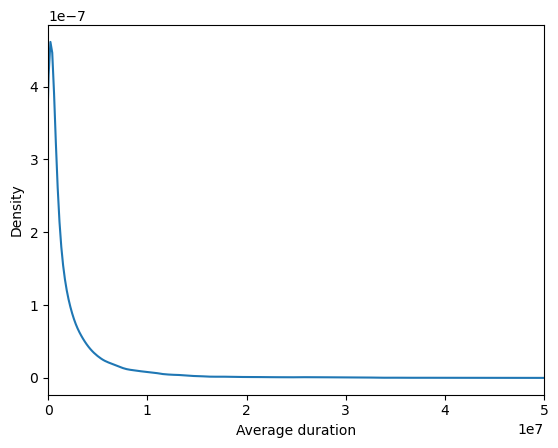

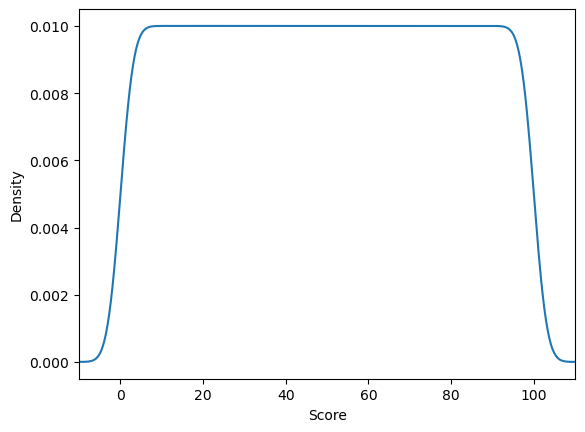

In [52]:
df_rule_avg_duration_pd['avg_duration'].plot.kde()
plt.xlabel('Average duration')
plt.ylabel('Density')
plt.title("")
plt.xlim(0e+8,0.50e+8)
plt.show()

df_rule_avg_duration_pd['Score5'].plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(-10,110)
plt.show()

In [53]:
type(df_avg_duration)

pyspark.sql.dataframe.DataFrame

# Ranking 6 - Frequency of each transaction

In [54]:
from pyspark.sql.functions import split
df_all = df_all.withColumn("date", split("Bought_Timestamp", " ")[0])
df_all = df_all.withColumn("time", split("Bought_Timestamp", " ")[1])

In [55]:
df_frequency = df_all.groupBy("buyer").agg(countDistinct("time").alias("frequency"))
df_rule_frequency_pd = df_frequency.toPandas()

percentiles = df_rule_frequency_pd['frequency'].rank(pct=True)
df_rule_frequency_pd['Score6'] = percentiles * 100

print(df_rule_frequency_pd)
#print unique score5 values assigned
print(df_rule_frequency_pd['Score6'].unique())
#converting to sparkdf
df_rule_frequency=spark.createDataFrame(df_rule_frequency_pd)

                                             buyer  frequency     Score6
0       \x2fddb28767a612ce6e76da99a32b1e9a69f8e432          4  85.276964
1       \x79141804d6c87dcb4e7ebb7d8aeb4db782518ec9          4  85.276964
2       \xaa145a17cab61c4bfcfa30d1a80229852f1bdb8c          3  77.613084
3       \xbdbb84bc1d8106b20b7ee96a7227e7544ef1fc2b          2  63.160964
4       \x2821b96b96e8e85dad078eefbd98662a4df8ec0b         10  97.788051
...                                            ...        ...        ...
186030  \xe282780e50937a2490831e4539bbb5f3f564e004          1  26.794420
186031  \xe0d3851eb01cde810436a054f4211e31a2fe0a82          1  26.794420
186032  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d          1  26.794420
186033  \xafee0a90deb063c23b8ca78a19669c09ac53b8c4          1  26.794420
186034  \x3e59244480f4941076aea8d5083dc0309bac2992          1  26.794420

[186035 rows x 3 columns]
[ 85.27696401  77.61308356  63.16096433  97.78805064  26.7944204
  89.83927756  94.76227592  98.9

In [99]:
df_rule_frequency_pd['frequency'].value_counts()

1     99693
2     35616
3     18156
4     10359
5      6616
6      4308
7      3085
8      2053
9      1489
10     1089
11      772
12      610
13      462
14      385
15      287
16      202
17      178
18      141
19       89
20       80
21       59
22       56
23       43
24       43
25       27
27       22
26       22
28       16
31       10
29       10
30        7
34        7
32        6
37        5
40        4
42        3
36        3
52        3
55        2
47        2
38        2
33        2
35        2
46        2
41        1
50        1
45        1
48        1
57        1
53        1
44        1
Name: frequency, dtype: int64

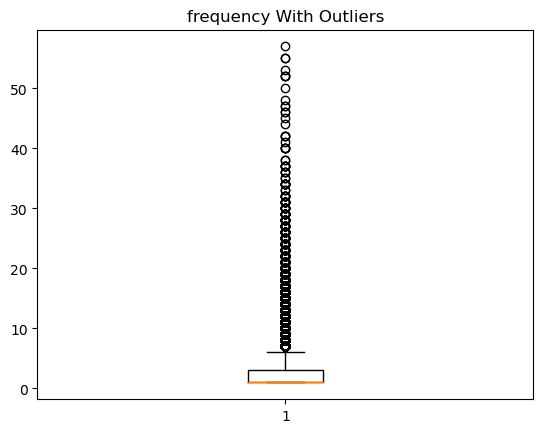

1    99693
2    35616
3    18156
Name: frequency, dtype: int64


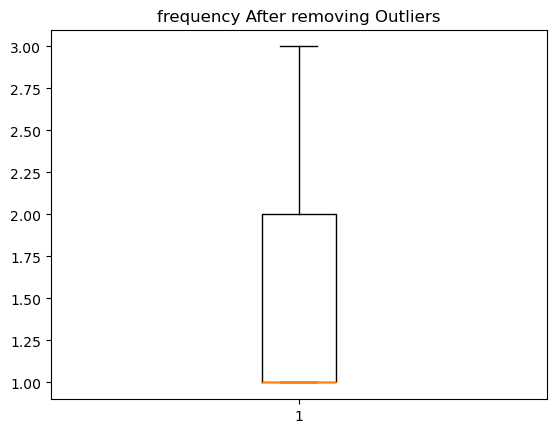

In [112]:
plt.boxplot(df_rule_frequency_pd['frequency'])
plt.title('frequency With Outliers')
plt.show()
Q1 = df_rule_frequency_pd['frequency'].quantile(0.25)
Q3 = df_rule_frequency_pd['frequency'].quantile(0.75)
IQR = Q3 - Q1

# Identify any values that fall outside of 1.5 times the IQR
outliers_df_rule_frequency_pd = df_rule_frequency_pd[(df_rule_frequency_pd['frequency'] >= Q1 - 0.4*IQR) & (df_rule_frequency_pd['frequency'] <= Q3 + 0.4*IQR)]
print(outliers_df_rule_frequency_pd['frequency'].value_counts())
plt.boxplot(outliers_df_rule_frequency_pd['frequency'])
plt.title('frequency After removing Outliers')
plt.show()

In [57]:
df_rule_frequency_pd.sort_values(by = 'frequency', ascending = False)

,buyer,frequency,Score6
138897,\xa43958e85e4a64977a9d3d2c6a053808aa5a9ed6,57,100.000000
48482,\x6599ec8d67f5258409cd0b01d320abc08b74ddb6,55,99.999194
25016,\xbf90e9e29f342a5de69aad99a6f307f9b9a373d1,55,99.999194
140692,\xc3e546894d06575593caf275bd068be0e8e8a907,53,99.998387
68228,\x23f838dd79fb3e5dc82b6b311eec2f4a14591bf9,52,99.997312
...,...,...,...
92760,\x8bbd915fb30dec224dd760da37bb15f7cac653b2,1,26.794420
18808,\xb42ee7ae1f983db010f55bbeac9c01cd07bb539f,1,26.794420
18809,\xe969fcbdf0a2e361d0b33981ee94f68aff2c8db5,1,26.794420
92756,\xb2c0329bb51f17396083528eed22e0299e18e842,1,26.794420


In [58]:
# df_frequency = df_all.groupBy("buyer").agg(countDistinct("time").alias("frequency"))
# df_rule_frequency_pd = df_frequency.toPandas()
# hist, bins=pd.cut(df_rule_frequency_pd['frequency'],bins=100,labels=False,retbins=True,right=False)
# df_rule_frequency_pd['Score6']=hist
# df_rule_frequency_pd['Score6']+=1
# print(df_rule_frequency_pd)
# #print unique score5 values assigned
# print(df_rule_frequency_pd['Score6'].unique())
# #converting to sparkdf
# df_frequency=spark.createDataFrame(df_rule_frequency_pd)

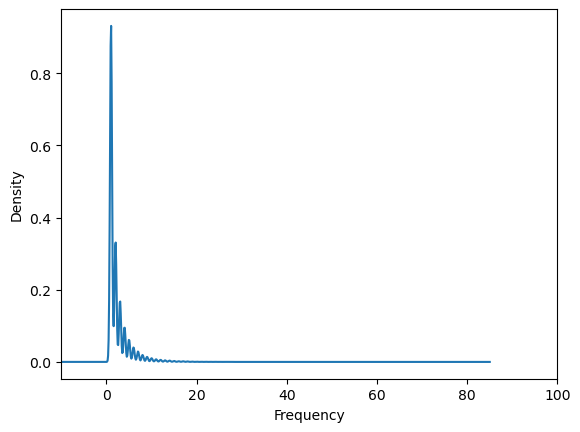

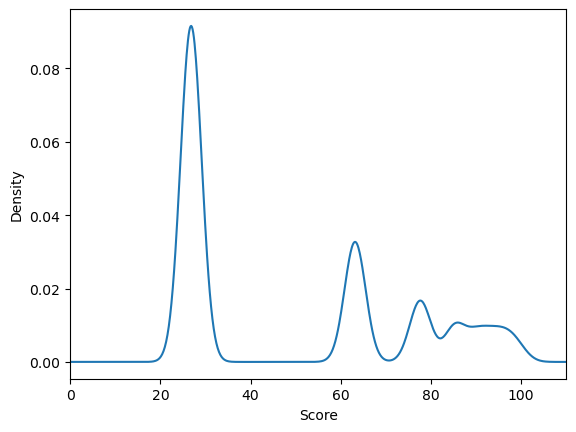

In [59]:
df_rule_frequency_pd['frequency'].plot.kde()
plt.xlabel('Frequency')
plt.ylabel('Density')
plt.title("")
plt.xlim(-10,100)
plt.show()

df_rule_frequency_pd['Score6'].plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(0,110)
plt.show()

# Feature Extraction for Model

In [60]:
# modeldata = reduce(lambda x,y: pd.merge(x,y, on='buyer', how='outer'), [df_avg, df_count, df_num_nftcontract, df_currency, df_avg_duration])
joined_df = df_avg.join(df_count, on='buyer', how='inner').join(df_num_nftcontract, on='buyer', how='inner').join(df_currency, on='buyer', how='inner').join(df_avg_duration, on='buyer', how='inner').join(df_frequency, on='buyer', how='inner')

In [61]:
joined_df.show(5)

23/04/19 11:58:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:08 WARN RowBasedKeyValueBatch: Calling spill() on

23/04/19 11:58:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:15 WARN RowBasedKeyValueBatch: Calling spill() on

23/04/19 11:58:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/19 11:58:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/19 11:58:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+-------------------+-----------+---------------+------------+------------------+---------+
|               buyer|          avg_spent|number_txns|num_nftcontract|num_currency|      avg_duration|frequency|
+--------------------+-------------------+-----------+---------------+------------+------------------+---------+
|\x000000000027634...|-1094.1415000000002|          2|              2|           1|         1012977.0|        2|
|\x0000002b94395a5...| 18.830347000000003|          1|              1|           1|           53640.0|        1|
|\x00052fb2f4c461b...|         5686.01735|          2|              1|           2|         1696346.0|        2|
|\x0005bb8bdcbbf4a...| 288.20619921428573|          7|              1|           1|256193.85714285713|        7|
|\x0007a07be3fc1a3...|-305.52065600000003|          1|              1|           1|          208449.0|        1|
+--------------------+-------------------+-----------+---------------+------------+-------------

In [62]:
joined_df.count()

186035

In [63]:
joined_scores = df_rule_avg_spent.join(df_rule_number_txns, on='buyer', how='inner').join(df_rule_num_nftcontract, on='buyer', how='inner').join(df_rule_num_currency, on='buyer', how='inner').join(df_rule_avg_duration, on='buyer', how='inner').join(df_rule_frequency, on='buyer', how='inner')
joined_scores.show(5)

23/04/19 11:59:18 WARN TaskSetManager: Stage 164 contains a task of very large size (1435 KiB). The maximum recommended task size is 1000 KiB.
23/04/19 11:59:18 WARN TaskSetManager: Stage 165 contains a task of very large size (1280 KiB). The maximum recommended task size is 1000 KiB.


23/04/19 11:59:19 WARN TaskSetManager: Stage 166 contains a task of very large size (1280 KiB). The maximum recommended task size is 1000 KiB.


23/04/19 11:59:19 WARN TaskSetManager: Stage 167 contains a task of very large size (1280 KiB). The maximum recommended task size is 1000 KiB.


23/04/19 11:59:20 WARN TaskSetManager: Stage 168 contains a task of very large size (1435 KiB). The maximum recommended task size is 1000 KiB.


23/04/19 11:59:20 WARN TaskSetManager: Stage 169 contains a task of very large size (1280 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-------------------+------------------+-----------+------------------+---------------+------------------+------------+------------------+------------------+------------------+---------+------------------+
|               buyer|          avg_spent|            Score1|number_txns|            Score2|num_nftcontract|            Score3|num_currency|            Score4|      avg_duration|            Score5|frequency|            Score6|
+--------------------+-------------------+------------------+-----------+------------------+---------------+------------------+------------+------------------+------------------+------------------+---------+------------------+
|\x000000000027634...|-1094.1415000000002|               0.0|          2|61.975165963393984|              2| 75.54573064208347|           1|48.130728088800495|         1012977.0| 55.64383046200984|        2|63.160964334668215|
|\x0000002b94395a5...| 18.830347000000003|11.084771018587505|          1|26.398527158867957|

In [64]:
joined_scores.write.parquet("/Users/rose/Documents/ModelScores/")


23/04/19 11:59:22 WARN TaskSetManager: Stage 177 contains a task of very large size (1435 KiB). The maximum recommended task size is 1000 KiB.
23/04/19 11:59:22 WARN TaskSetManager: Stage 178 contains a task of very large size (1280 KiB). The maximum recommended task size is 1000 KiB.
23/04/19 11:59:22 WARN TaskSetManager: Stage 179 contains a task of very large size (1280 KiB). The maximum recommended task size is 1000 KiB.


23/04/19 11:59:23 WARN TaskSetManager: Stage 180 contains a task of very large size (1280 KiB). The maximum recommended task size is 1000 KiB.


23/04/19 11:59:23 WARN TaskSetManager: Stage 181 contains a task of very large size (1435 KiB). The maximum recommended task size is 1000 KiB.


23/04/19 11:59:24 WARN TaskSetManager: Stage 182 contains a task of very large size (1280 KiB). The maximum recommended task size is 1000 KiB.


23/04/19 11:59:25 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
